<a href="https://colab.research.google.com/github/sarahlai30/Machine-Learning-INDE-577/blob/main/Supervised%20Learning/Logistic_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Logistic Regression

The goal of logistic regression is to predict a probability for a binary classification task (e.g., whether an event will occur: Yes/No, 1/0).
First, like linear regression, it computes the weighted sum of inputs and bias. Then, it applies a sigmoid function (the "magic function") to transform 𝑧 into a value between 0 and 1. This transformed value
𝜎 (𝑧) represents the probability that the given input belongs to the positive class (label 1).



### Why Use Probabilistic Neuron Output?

In earlier binary classification problems, such as when we applied the perceptron model, we assumed that the data was linearly separable. However, in many real-world scenarios, this assumption does not hold. A probabilistic neuron output allows us to predict probabilities instead of binary labels, making the model more flexible and better suited to handling overlapping classes or non-linearly separable data.

In this example, we will be predicting whether a banknote is authentic or not based on its variance.

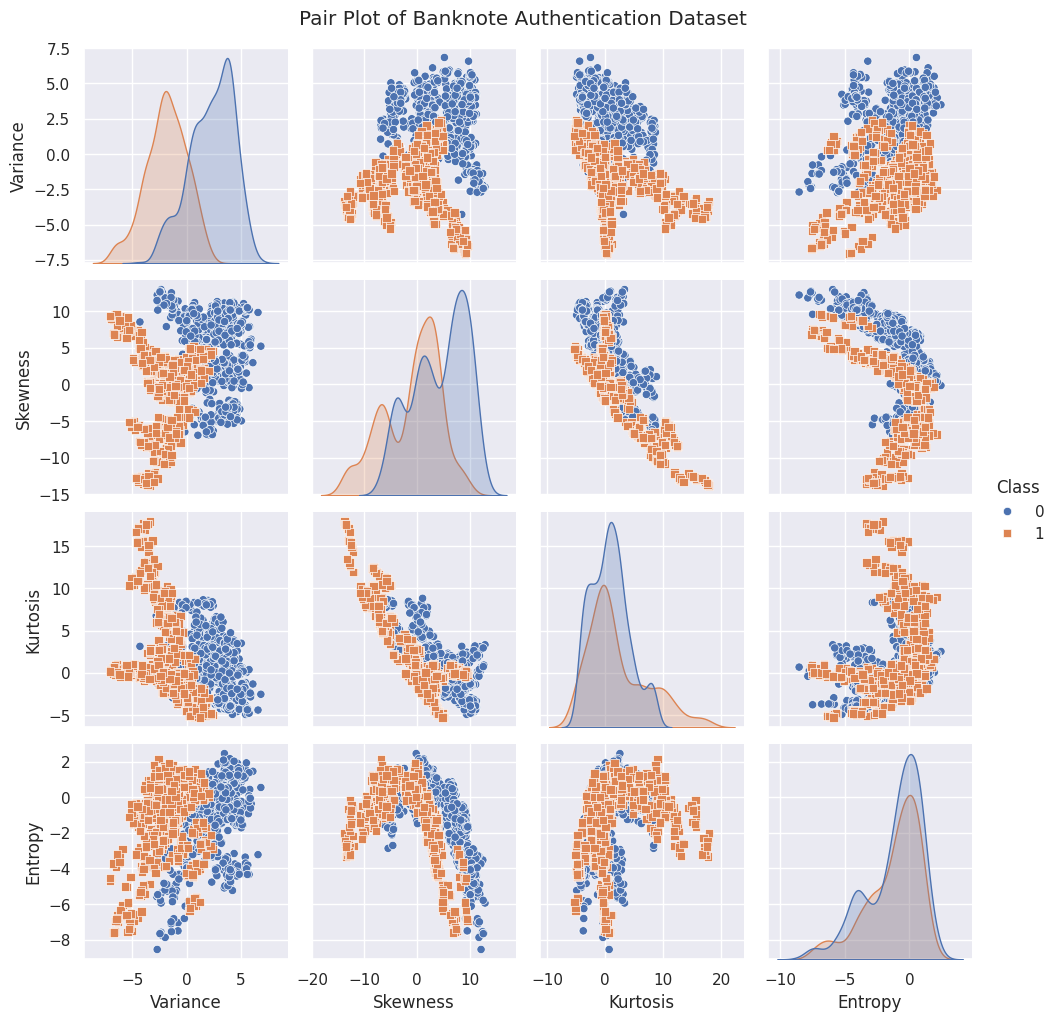

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from mlxtend.plotting import plot_decision_regions

# Set the Seaborn theme
sns.set_theme()
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt"
columns = ["Variance", "Skewness", "Kurtosis", "Entropy", "Class"]
df = pd.read_csv(url, names=columns)
pair_plot = sns.pairplot(df, hue="Class", diag_kind="kde", markers=["o", "s"],
                         vars=["Variance", "Skewness", "Kurtosis", "Entropy"])

# Add a title to the pair plot
pair_plot.fig.suptitle("Pair Plot of Banknote Authentication Dataset", y=1.02)

# Show the plot
plt.show()


We can see that most of these plots are not able to separate the classes with a linear function. But looking at the variance and entropy plot, the forged banknotes look to have a higher variance than the authentic banknotes.

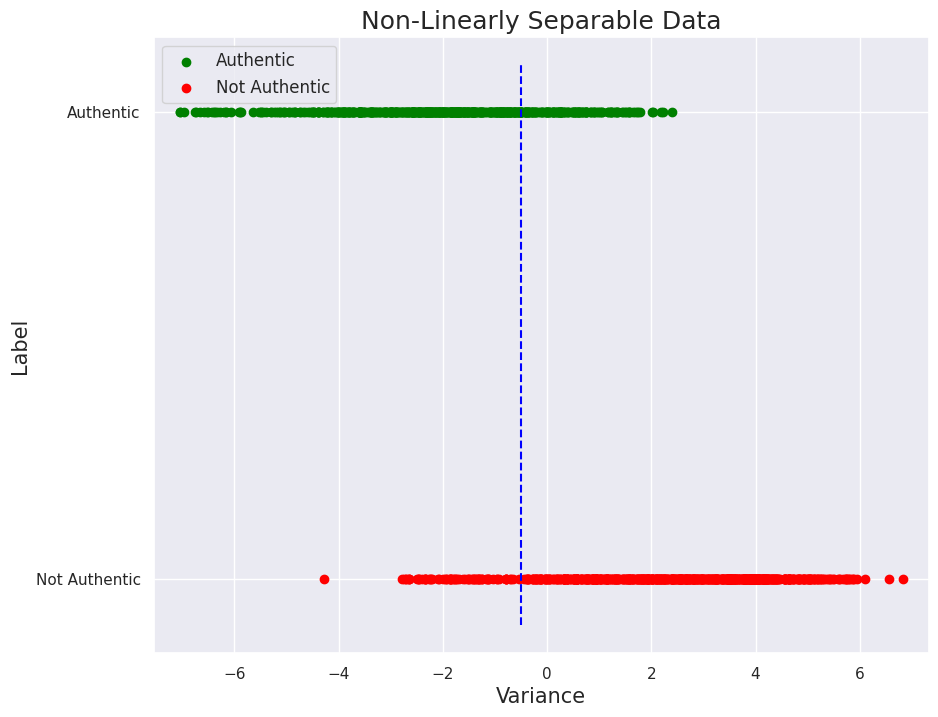

In [ ]:
import matplotlib.pyplot as plt

authentic = df[df["Class"] == 1]  # Class 1: Authentic
not_authentic = df[df["Class"] == 0]  # Class 0: Not Authentic

x_min = min(df["Variance"]) - 0.5  # Extend a little for better visualization
x_max = max(df["Variance"]) + 0.5

plt.figure(figsize=(10, 8))
plt.xlim((x_min, x_max))

# Scatter plot for each class with distinct colors
plt.scatter(authentic["Variance"], np.ones(len(authentic)), color="green", label="Authentic")
plt.scatter(not_authentic["Variance"], np.zeros(len(not_authentic)), color="red", label="Not Authentic")

# Add a vertical line for separation
plt.vlines(-0.5, -0.1, 1.1, color="blue", linestyle="--")

# Labels and title
plt.xlabel("Variance", fontsize=15)
plt.ylabel("Label", fontsize=15)
plt.yticks([0, 1], ["Not Authentic", "Authentic"])  # Set y-ticks to make it look like the example
plt.legend(fontsize=12, loc="upper left")
plt.title("Non-Linearly Separable Data", fontsize=18)
plt.show()



Instead of creating a single-neuron model that predicts a deterministic class label, we will now build a model that predicts a class probability. Like the previous models, such as the linear regression and single neurons, we first need to choose an activation function before selecting a cost or loss function.

The sigmoid function is differentiable and maps input values into a range of (0,1) making it ideal for transforming pre-activation values into probabilities. Its smooth, "S"-shaped curve is particularly well-suited for classification tasks where we expect probabilities to transition gradually as the input features change.

This approach allows us to model uncertainty in predictions, rather than simply assigning a deterministic class label. By outputting probabilities, the model becomes more flexible and interpretable, especially in cases where classes overlap or the decision boundary is not perfectly clear.



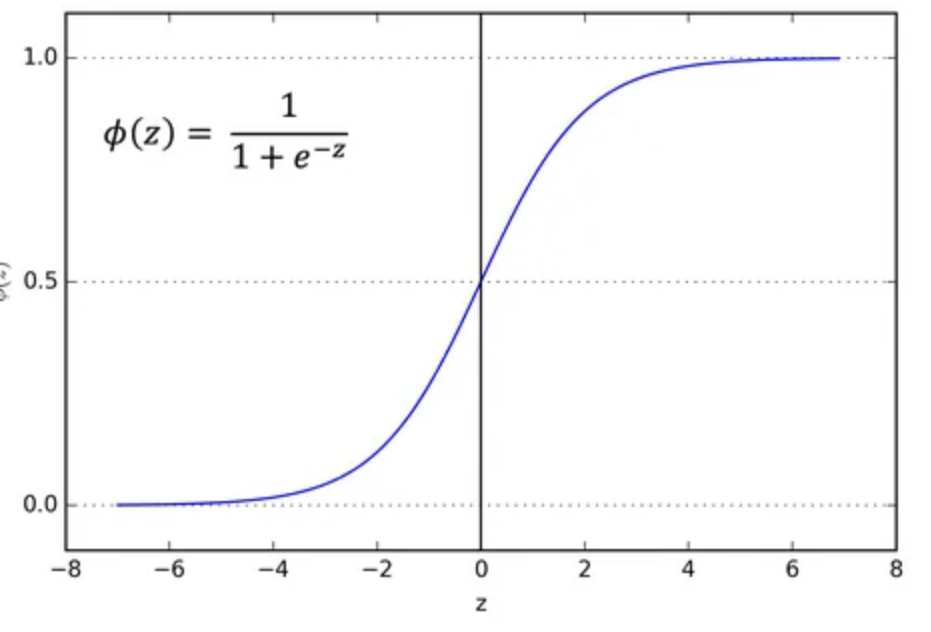

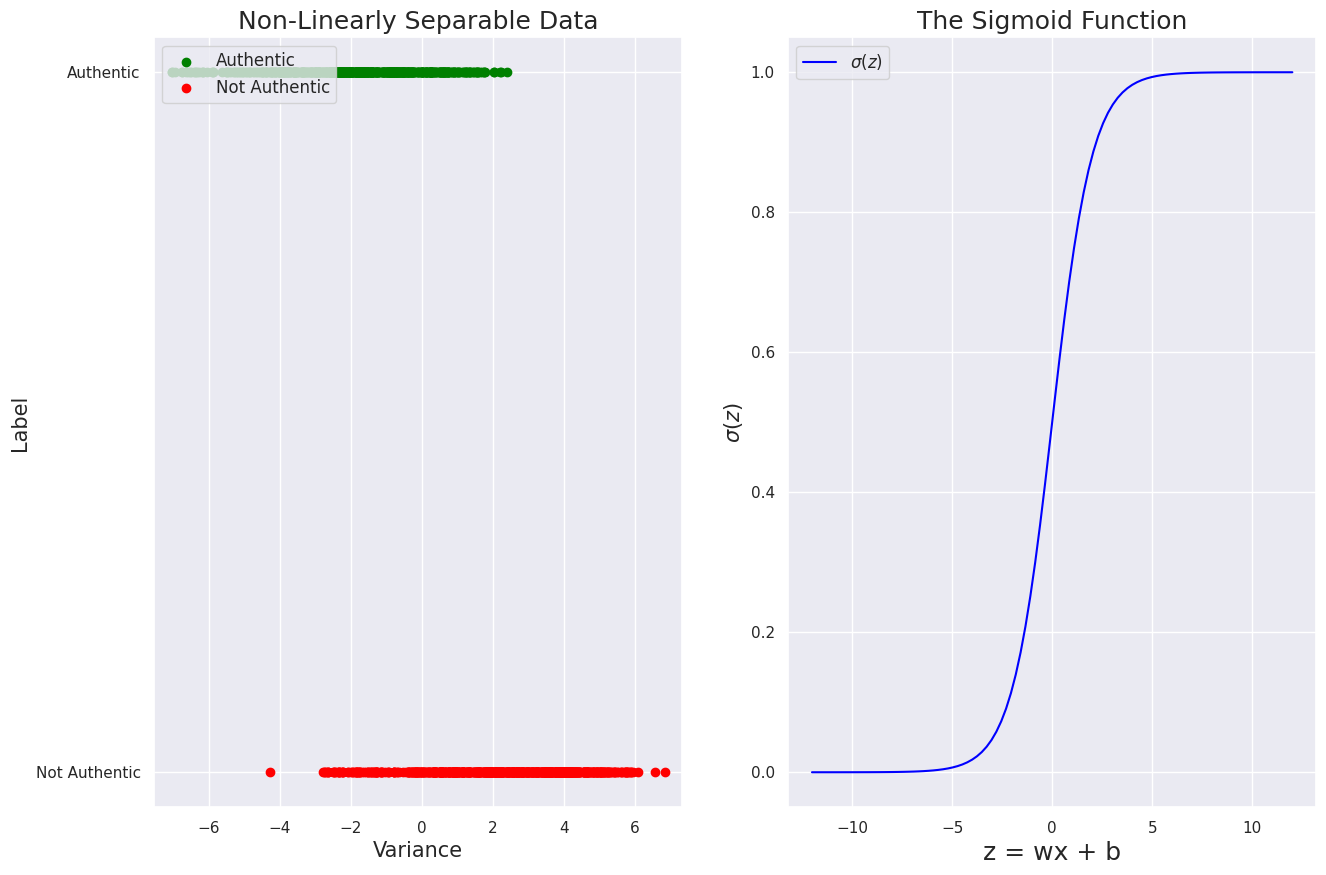

In [ ]:
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

# Set up subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))

# Scatter plot for authentic vs. not authentic based on Variance
x_min = min(df["Variance"]) - 0.5
x_max = max(df["Variance"]) + 0.5
ax1.set_xlim((x_min, x_max))

ax1.scatter(authentic["Variance"],
            np.ones(len(authentic)),
            color="green",
            label="Authentic")
ax1.scatter(not_authentic["Variance"],
            np.zeros(len(not_authentic)),
            color="red",
            label="Not Authentic")

ax1.set_xlabel("Variance", fontsize=15)
ax1.set_ylabel("Label", fontsize=15)
ax1.set_yticks([0, 1], ["Not Authentic", "Authentic"])
ax1.set_title("Non-Linearly Separable Data", fontsize=18)
ax1.legend(fontsize=12, loc="upper left")

# Plot the sigmoid function in the second subplot
domain = np.linspace(-12.0, 12.0, 100)
ax2.plot(domain, sigmoid(domain), color="blue", label=r"$\sigma(z)$")
ax2.set_xlabel("z = wx + b", fontsize=18)
ax2.set_ylabel(r"$\sigma(z)$", fontsize=15)
ax2.set_title("The Sigmoid Function", fontsize=18)
ax2.legend(fontsize=12)

plt.show()

As shown in the figures above, the pre-activation values for variance might effectively map the variance measurements to appropriate inputs for the sigmoid function. This would enable the post-activation values to correctly represent the probability of a banknote being authentic or not authentic. To test this hypothesis further, we need to introduce a cost/loss function into our single neuron model.

We use Binary Cross-Entropy Loss to minimize the error, allowing the model to learn probabilities that closely align with the true labels. This provides a mathematically sound approach to training logistic regression neurons.

The goal is to predict the probability of each label using a sigmoid function while maximizing the likelihood of correct predictions. By leveraging the derivative of the sigmoid function, we can compute the gradient of the loss with respect to the weights and bias, which is then used to update the model parameters during stochastic gradient descent.

Now defining a custom SingleNeuron class:

In [ ]:
class SingleNeuron:
    def __init__(self, activation_function, cost_function, alpha=0.005, epochs=50):
        """
        Single Neuron model with a customizable activation function.

        Parameters:
            activation_function: function, the activation function (e.g., np.tanh, sigmoid).
            alpha: float, learning rate (default 0.005).
            epochs: int, number of training epochs (default 50).
        """
        self.activation_function = activation_function
        self.cost_function = cost_function
        self.alpha = alpha
        self.epochs = epochs

    def train(self, X, y):
        """
        Train the neuron using gradient descent.

        Parameters:
            X: ndarray, shape (n_samples, n_features) - Training data.
            y: ndarray, shape (n_samples,) - Target values.

        Returns:
            self
        """
        # Initialize weights
        self.w_ = np.random.rand(1 + X.shape[1])
        self.errors_ = []
        N = X.shape[0]

        for _ in range(self.epochs):
            errors = 0
            for xi, target in zip(X, y):
                error = (self.predict(xi) - target)
                # Update weights for each feature and bias
                self.w_[:-1] -= self.alpha * error * xi
                self.w_[-1] -= self.alpha * error
                errors += 0.5 * (error ** 2)
            # Track the mean squared error for each epoch
            self.errors_.append(errors / N)
        return self

    def predict(self, X):
        """
        Make predictions with the neuron.

        Parameters:
            X: ndarray, shape (n_samples, n_features) - Input data.

        Returns:
            Output after applying the activation function.
        """
        # Compute the linear combination
        preactivation = np.dot(X, self.w_[:-1]) + self.w_[-1]
        # Apply the activation function
        return self.activation_function(preactivation)

    def plot_cost_function(self):
        """Plot the cost function over epochs."""
        plt.figure(figsize=(10, 8))
        plt.plot(range(1, len(self.errors_) + 1), self.errors_, label="Cost function")
        plt.xlabel("Epochs", fontsize=15)
        plt.ylabel("Cost", fontsize=15)
        plt.legend(fontsize=15)
        plt.title("Cost Calculated after Each Epoch During Training", fontsize=18)
        plt.show()

    def plot_decision_boundary(self, X, y, xstring="x", ystring="y"):
        """Plot the decision boundary using mlxtend's plot_decision_regions function."""
        plt.figure(figsize=(10, 8))
        plot_decision_regions(X, y, clf=self)
        plt.title("Neuron Decision Boundary", fontsize=18)
        plt.xlabel(xstring, fontsize=15)
        plt.ylabel(ystring, fontsize=15)
        plt.show()


Before instantiating an instance of the SingleNeuron class, we first need to implement a function for the Binary Cross-Entropy loss. Once the loss function is defined, we can create an instance of the SingleNeuron class.

Next, we extract the variance measurements from the dataset and convert them into a NumPy array, reshaping it into a column vector. We also create a target array, assigning the labels 1 for authentic banknotes and 0 for inauthentic banknotes.

Finally, with our feature vector and target vector prepared, we can pass these values to the SingleNeuron.train() method to train the logistic neuron using stochastic gradient descent.

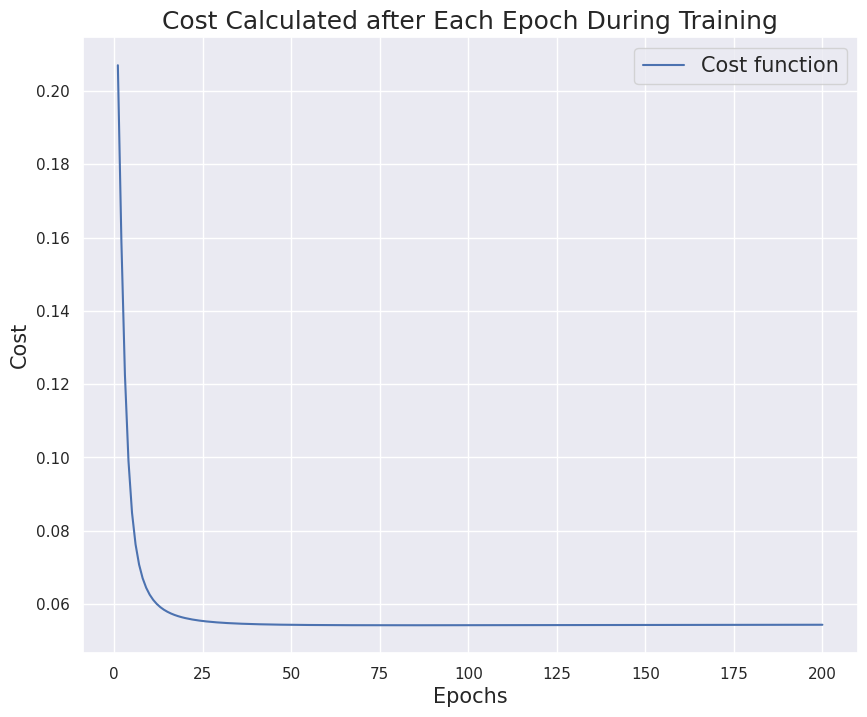

In [ ]:
def cross_entropy_loss(y_hat, y):
    # Clip predictions to prevent log(0) errors
    epsilon = 1e-10
    y_hat = np.clip(y_hat, epsilon, 1 - epsilon)

    # Compute cross-entropy loss
    return - (y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat)).mean()
X = df['Variance'].values.reshape(-1, 1)
y = np.where(df['Class'] == 1, 1, 0)

# Instantiate the neuron with sigmoid activation and cross-entropy loss
node = SingleNeuron(sigmoid, alpha=0.0001, epochs=200)
node.train(X, y)

In [ ]:
node.plot_cost_function()

NameError: name 'node' is not defined

After training the variable node, we can now visualize the binary cross entropy loss over each epoch by plotting the values in the SingleNeuron.errors_ attribute.

Visualizing the cost function across epochs during training allows us to verify that the neuron is learning effectively over time. Next, we can visualize the hypothesis function—or prediction function—to understand how well the model approximates the true target function. Recall that in supervised machine learning, the goal is to learn a function 𝑓 that closely approximates the true target function 𝑓 ∗.

To do this, we can plot the predictions from the SingleNeuron.predict() method over the corresponding scattered data points.

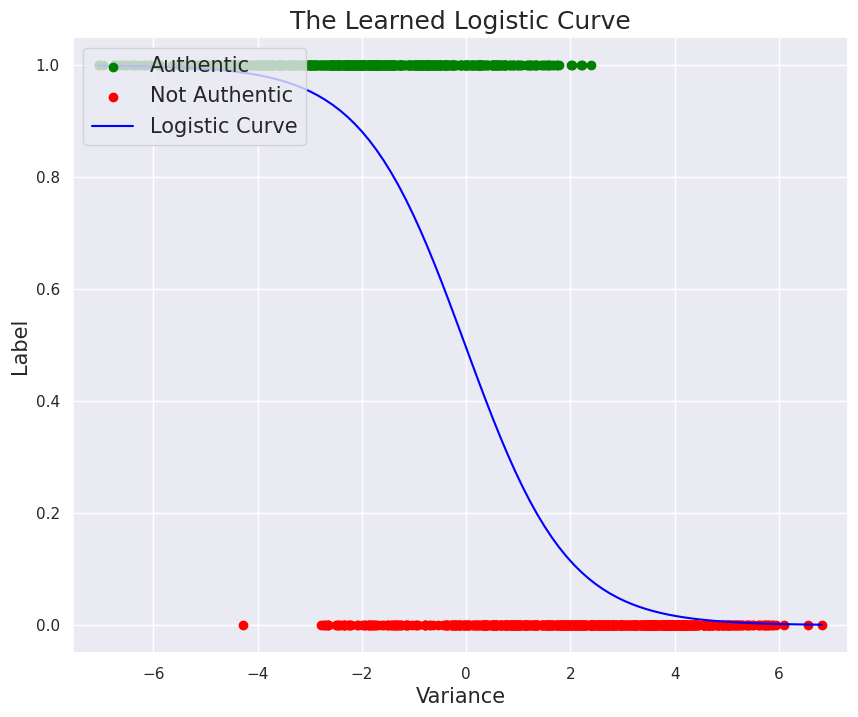

In [ ]:
plt.figure(figsize=(10, 8))

# Define x-axis range based on Variance values
plt.xlim((df['Variance'].min() - 0.5, df['Variance'].max() + 0.5))

# Scatter plot for the two classes
authentic = df[df['Class'] == 1]
not_authentic = df[df['Class'] == 0]

plt.scatter(authentic['Variance'],
            np.ones(authentic.shape[0]),
            color="green",
            label="Authentic")
plt.scatter(not_authentic['Variance'],
            np.zeros(not_authentic.shape[0]),
            color="red",
            label="Not Authentic")

# Generate domain for the Variance feature to plot the logistic curve
domain = np.linspace(df['Variance'].min(), df['Variance'].max(), 100)
plt.plot(domain, node.predict(domain.reshape(-1, 1)), color='blue', label="Logistic Curve")

# Labels and title
plt.xlabel("Variance", fontsize=15)
plt.ylabel("Label", fontsize=15)
plt.legend(fontsize=15, loc="upper left")
plt.title("The Learned Logistic Curve", fontsize=18)
plt.show()


To classify data using the trained logistic single neuron, we convert the predicted probabilities into binary labels (0 or 1) by rounding them with np.rint(node.predict(X)). To calculate the classification error, we compare these binary predictions to the true labels (y) using the != operator, which returns True for mismatches and False for matches. The mismatches are converted into integers using .astype(int), where 1 represents an error and 0 represents a correct classification. Finally, the classification error is computed as the proportion of mismatches in the dataset using sum(classification_error) / len(y).

In [ ]:
np.rint(node.predict(X)) != y
classification_error = (np.rint(node.predict(X)) != y).astype(int)
print(f"Classification Error = {sum(classification_error)/ len(y)}")

Classification Error = 0.15597667638483964


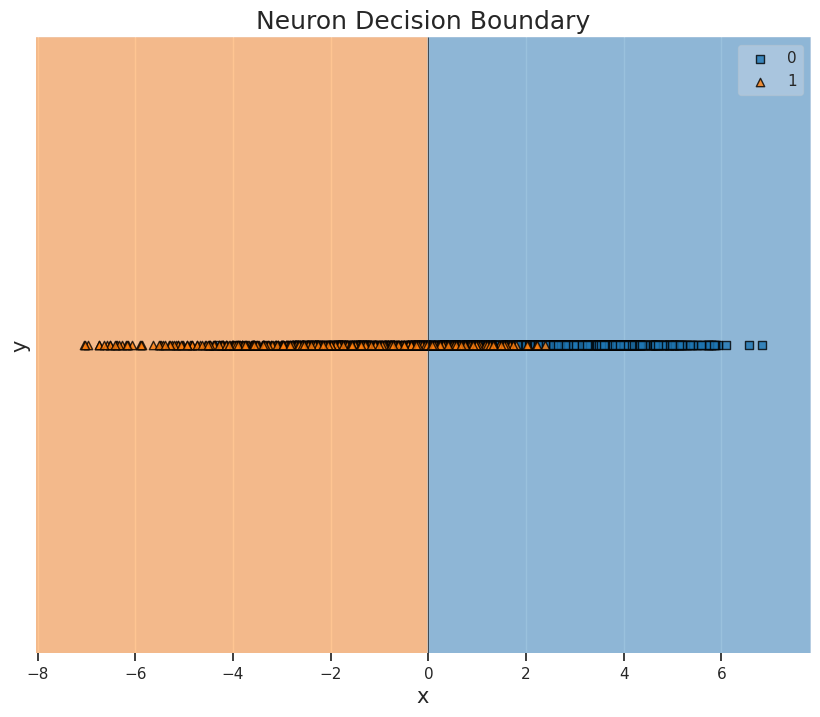

In [ ]:
node.plot_decision_boundary(X, y)
plt.show()

We compare the training of a single neuron model in two scenarios:

Training with a single feature: Variance.
Training with two features: Variance and Skewness.

The cross-entropy loss is plotted for both scenarios during training to visualize the performance of the models.

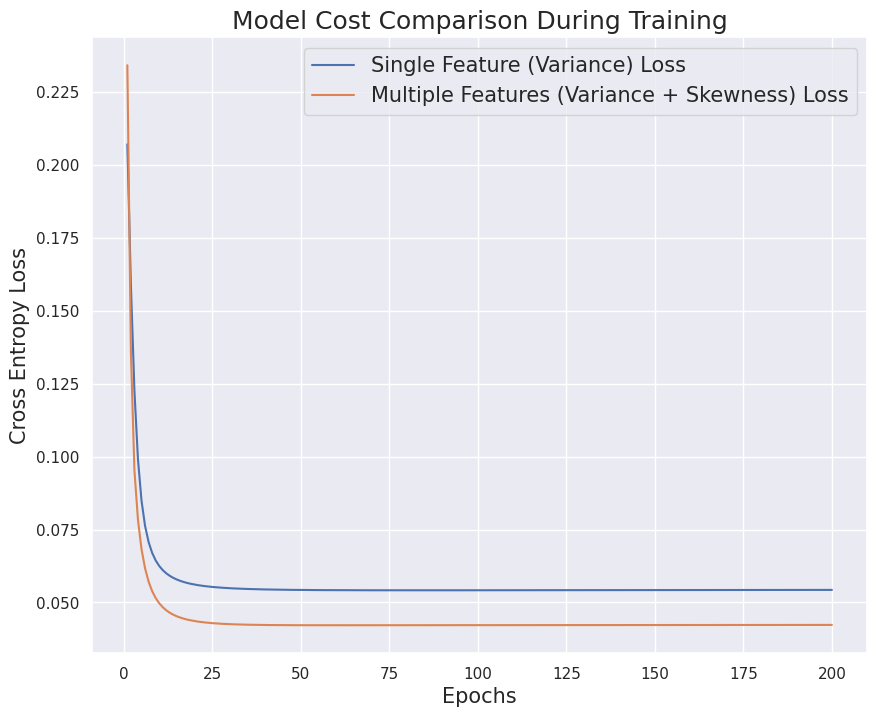

In [ ]:
node_two = SingleNeuron(sigmoid, cross_entropy_loss, alpha=0.0001, epochs=200)

# Select multiple features from the banknote data (e.g., Variance and Skewness)
X_two = df[["Variance", "Skewness"]].values  # Multiple features
y = df["Class"].values
# Train the new single neuron model on the multiple feature inputs
node_two.train(X_two, y)

# Plot the cross-entropy loss for both single and multiple feature models
plt.figure(figsize=(10, 8))

# Plot the loss for the single feature model (node)
plt.plot(range(1, len(node.errors_) + 1),
         node.errors_,
         label="Single Feature (Variance) Loss")

# Plot the loss for the multiple feature model (node_two)
plt.plot(range(1, len(node_two.errors_) + 1),
         node_two.errors_,
         label="Multiple Features (Variance + Skewness) Loss")

# Customize the plot
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Cross Entropy Loss", fontsize=15)
plt.legend(fontsize=15)
plt.title("Model Cost Comparison During Training", fontsize=18)
plt.show()


From the plot, we observe that the single-feature model performs reasonably well but is limited by the amount of information provided by a single feature (Variance). This limitation is reflected in its slightly higher final loss, indicating reduced performance compared to the two-feature model.

Adding Skewness as a second feature enhances the model’s learning process by providing additional information for classification. This results in faster convergence during training and better overall performance, as evidenced by the lower final loss.

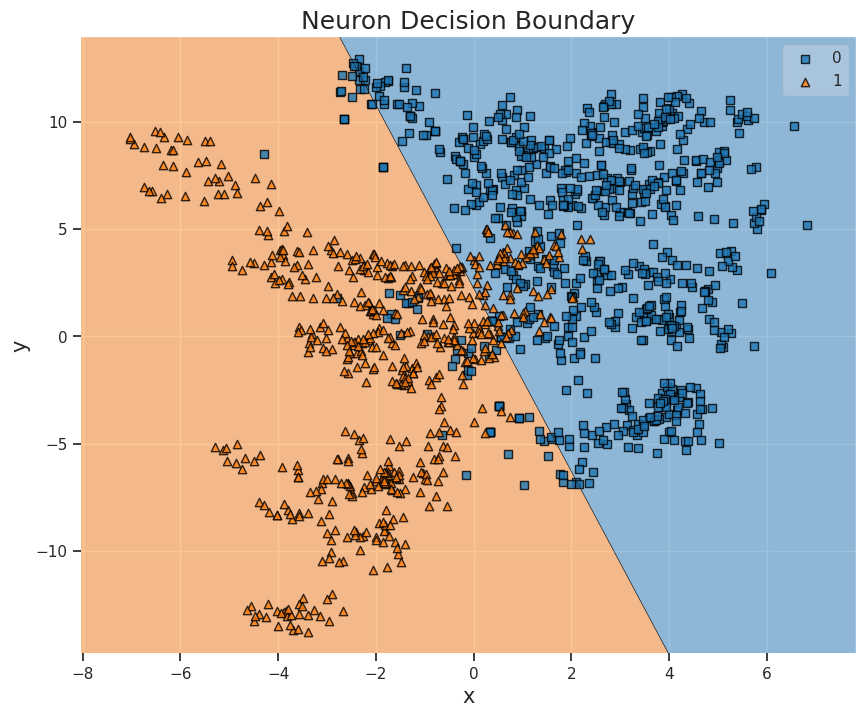

In [ ]:
node_two.plot_decision_boundary(X_two, y)

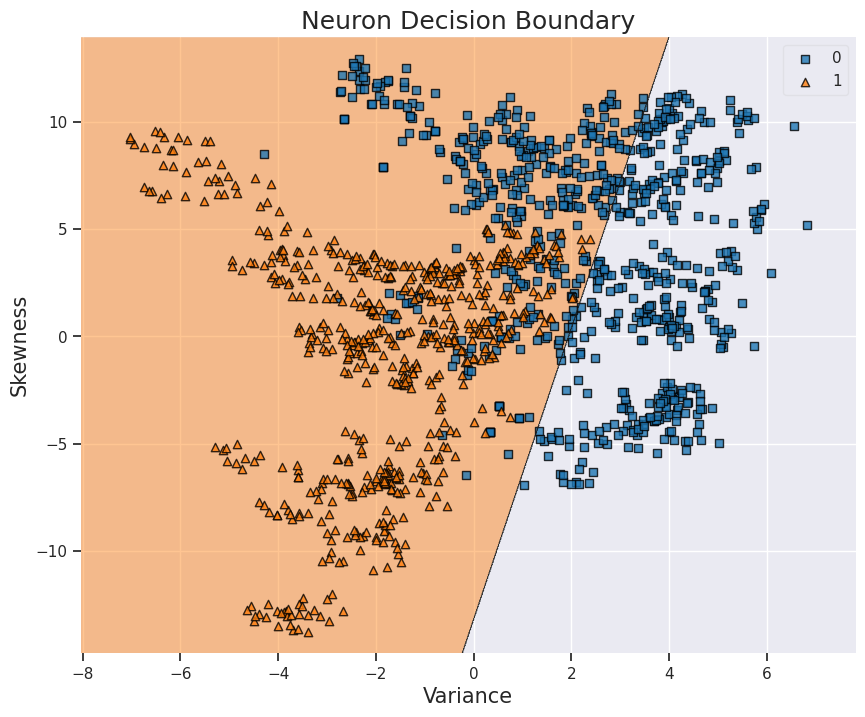

In [ ]:
def sign(z):
    return np.sign(z)

def MSE(y_hat, y):
    return 0.5 * (y_hat - y) ** 2

# Instantiate a new single neuron with sign activation and MSE loss.
node_three = SingleNeuron(sign, MSE, alpha=0.0001, epochs=1000)

# Select 'Variance' and 'Skewness' as features for classification.
# Assuming `banknote_data` is the DataFrame containing the banknote dataset.
X_three = df[["Variance", "Skewness"]].values
y_three = df["Class"].values

# Train the neuron on the feature vectors and labels.
node_three.train(X_three, y_three)

# Plot the decision boundary to visualize model performance.
node_three.plot_decision_boundary(X_three, y_three, xstring="Variance", ystring="Skewness")
plt.show()


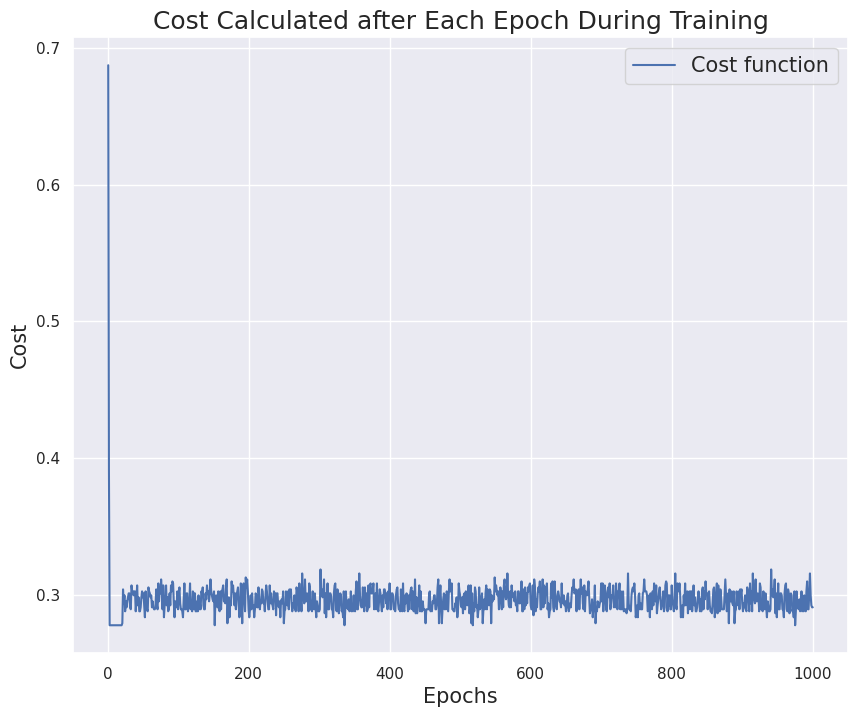

In [ ]:
node_three.plot_cost_function()